# Vehicle Kinematics Examples

This code experiments with kinematic models commonly used in the autonomous mobile robot and vehicle domains.

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.integrate import solve_ivp
from math import cos, sin, pi
from functools import partial

Let's start with our simple unicycle equations of motion - control inputs are simply the forward speed, $v$, and rotational speed, $\omega$.
We implement the dynamics as a python function that depends on time, position, and input signals.

The **state** of the vehicle is defined as $\dot{x} = [x \ y \ \theta]^T$.

In [22]:
# I provide by default no control input.
def unicycle_motion(t, x, u_fn=lambda t, x : [0,0]):
    """
    Parameters:
    t : float
        current time
    x : list(float)
        current state
    u_fn : function
        control function; defaults to no control input
    """
    [v, omega] = u_fn(t, x)
    theta = x[2]
    x_dot = v*cos(theta)
    y_dot = v*sin(theta)
    theta_dot = omega
    return [x_dot, y_dot, theta_dot]

The above function returns the values for $\dot{x}$, the instantaneous change of all state variables.
We need to simulate in a **discrete** environment, since we are using a computer!
To do so, we will use numerical integration to compute the trajectories of the state under different control inputs.
This process solves the **initial value problem** (IVP) using [`scipy.integrate.solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp).

In [23]:
# Final time - we will run for 10 seconds
t_f = 10.0 
# Set the time span
t_span = (0.0, t_f)
# Initial state of the vehicle - the origin
x_0 = [0., 0., 0.]
# Define a fixed, open-loop controller that has a forward speed of v = 0.5 m/s
# and a rotational speed of pi/6 rad/s.
u_const_fn = lambda t,x : [0.5, pi/6.0]
# Some fancy python footwork to bind this lambda to the unicycle motion model
model_fn = partial(unicycle_motion, u_fn=u_const_fn)

In [24]:
# Invoke the IVP solver using Runge-Kutta 23 algorithm. This is a nonlinear system, so we need something better than Euler integration.
# It returns a solution structure with the state values for plotting.
soln = solve_ivp( model_fn, t_span, x_0, method='RK23', dense_output=False )

In [25]:
# Key data stored in the soln structure
T = soln.t
X = soln.y

In [26]:
# Let's plot the (x,y) evolution of the unicycle
def plot_xy_trajectory(X, xlim=None, ylim=None):
    fig,ax = plt.subplots(1)
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    plt.plot(X[0,:], X[1,:], 'b--')
    plt.plot(0., 0., 'k*')
    plt.plot(X[0,-1], X[1,-1], 'go')

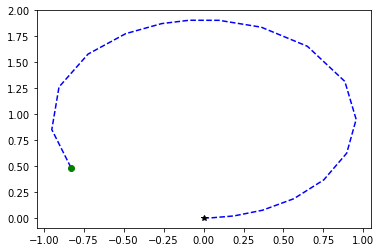

In [27]:
plot_xy_trajectory(X)

In [28]:
# For grins, let's make a time varying open-loop controller that oscillates the angular speed and reduces the forward speed.
def open_loop(t, x, t_f, alpha=0.1):
    u_1 = alpha*(t_f - t)
    u_2 = sin(pi*t)
    return [u_1, u_2]

In [29]:
model_fn2 = partial(unicycle_motion, u_fn=partial(open_loop, t_f=t_f))
soln2 = solve_ivp( model_fn2, t_span, x_0, method='RK23', dense_output=False )

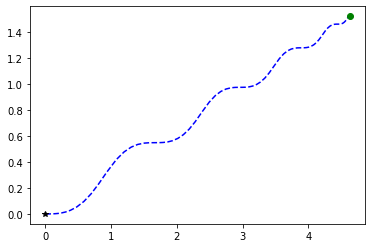

In [30]:
plot_xy_trajectory(soln2.y)